In [1]:
import os
import sys
import cv2
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

from skimage.segmentation import active_contour
from skimage.filters import gaussian
from cv2 import equalizeHist
from PIL import Image, ImageDraw
from torchvision import transforms

In [2]:
source_dir = 'C:\\Users\\user\\OneDrive\\桌面\\vertex\\content\\DATA\\16060746'
dest_dir = './content/pred_result/exp/labels'

# source_dir = 'C:/Users/user/OneDrive/桌面/vertex/content/DATA_unlabel/06253001'
# dest_dir = 'C:\\Users\\user\\OneDrive\\桌面\\vertex\\content\\pred_result\\exp2\\labels'

img_paths = [os.path.join(source_dir, filename) for filename in os.listdir(source_dir) if filename.endswith('.bmp')]
label_paths = [os.path.join(dest_dir, filename) for filename in os.listdir(dest_dir) if filename.endswith('.txt')]

sorted(img_paths)
sorted(label_paths)

for i in range(5):
    print(img_paths[i].split('\\')[-1])
    print(label_paths[i].split('\\')[-1])
    print('------')

16060746_FILE0.bmp
16060746_FILE0.txt
------
16060746_FILE1.bmp
16060746_FILE1.txt
------
16060746_FILE10.bmp
16060746_FILE10.txt
------
16060746_FILE11.bmp
16060746_FILE11.txt
------
16060746_FILE12.bmp
16060746_FILE12.txt
------


In [3]:
# %cd ./content/yolov5/
# %pwd

In [4]:
# !python ./detect.py --weights C:/Users/user/OneDrive/桌面/ressult_good/runs_result/exp/weights/best.pt --img 400 --conf 0.2 --source C:/Users/user/OneDrive/桌面/vertex/content/DATA_unlabel/06253001 --save-conf --save-txt --project ../pred_result

In [5]:
# %cd ../../

In [6]:
spine_pos_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4', 'L5']

def read_label(label_path, img_size):

    img_width, img_height = img_size

    with open(label_path, mode='r') as f:
        lines = f.readlines()
    
    temp_list = []
    for line in reversed(lines):

        temp_dict = dict()

        # read yolov5 output format
        lst = [float(a) for a in line.strip('\n').split(' ')]
        label, x_center_norm, y_center_norm, width_norm, height_norm, predict_conf = lst

        x_center = int(x_center_norm * img_width)
        y_center = int(y_center_norm * img_height)
        box_width = int(width_norm * img_width)
        box_height = int(height_norm * img_height)

        temp_dict['label'] = 'S' if label == 0 else 'others'
        temp_dict['x_center'] = x_center
        temp_dict['y_center'] = y_center
        temp_dict['box_width'] = box_width
        temp_dict['box_height'] = box_height
        temp_dict['conf'] = predict_conf
        temp_dict['path'] = label_path

        temp_list.append(temp_dict)

    temp_list.sort(key=lambda x: x.get('y_center'))

    # if find Sacral in image
    if temp_list[-1]['label'] == 'S':
        for idx in range(len(temp_list)-1):
            temp_list[-(idx+2)]['label'] = spine_pos_list[-(idx+1)]
    # if no Sacral, directly set the last vertext to L5
    else:
        for idx, temp in enumerate(reversed(temp_list)):
            temp['label'] = spine_pos_list[-(idx+1)]


    return temp_list

# *
imgs = [Image.open(img_path) for img_path in img_paths]
labels = [read_label(label_path, imgs[i].size) for i, label_path in enumerate(label_paths)]

In [7]:
class BuildModel(nn.Module):

    def __init__(self):
        
        super(BuildModel, self).__init__()
        
        # ----------------------------------------------
        # 初始化模型的 layer (input size: 224 * 224)

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2)
        )

        # ----------------------------------------------
               
    def forward(self, x):
        
        # ----------------------------------------------
        # Forward (final output 1 probability)

        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        # ----------------------------------------------

        return x

In [8]:
class BuildModel(nn.Module):

    def __init__(self):
        
        super(BuildModel, self).__init__()
        
        # ----------------------------------------------
        # 初始化模型的 layer (input size: 224 * 224)

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=11, stride=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Linear(1000, 2),
        )

        # ----------------------------------------------
               
    def forward(self, x):
        
        # ----------------------------------------------
        # Forward (final output 1 probability)

        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        # ----------------------------------------------

        return x

In [9]:
screw_model = torch.load(r'C:\Users\user\OneDrive\桌面\vertex\weights\Alexnet\screw_clf(2).pt', map_location = torch.device('cpu'))

In [10]:
# data.detectScrew(screw_model)

In [11]:
# data.plotDataset(list(range(len(data))))

In [12]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = TF.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [14]:
shape_model = torch.load(r'C:\Users\user\OneDrive\桌面\vertex\weights\Unet\unet0328H.opt', map_location=torch.device('cpu'))['model']
histeq = True

{'label': 'T11', 'x_center': 271, 'y_center': 509, 'box_width': 362, 'box_height': 376, 'conf': 0.932178, 'path': './content/pred_result/exp/labels\\16060746_FILE0.txt'}


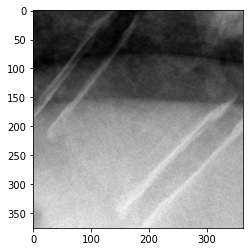

In [15]:
full_img, label = imgs[0], labels[0]
ix = 2
print(label[ix])
x_c, y_c = label[ix]['x_center'], label[ix]['y_center']
w, h = label[ix]['box_width'], label[ix]['box_height']
box = (x_c-w/2, y_c-h/2, x_c+w/2, y_c+h/2)
seg_img = full_img.crop(box)
plt.imshow(seg_img, cmap='gray')

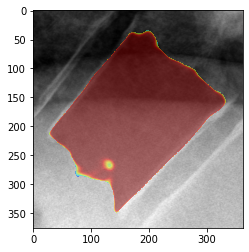

In [16]:
if histeq == True:
    input_img = Image.fromarray(equalizeHist(np.array(seg_img)))
else:
    input_img = seg_img

input_img = TF.resize(input_img, [224,224])
input_img = TF.to_tensor(input_img)

shape_model.eval()
output = shape_model(input_img.unsqueeze(0))
prob = torch.sigmoid(output)

prob = TF.resize(prob, [*(seg_img.size)][::-1])
outimg = prob.squeeze().detach().numpy()

masked = np.ma.masked_where(outimg < 0.8 , outimg)

plt.figure()
plt.imshow(seg_img, cmap='gray')
plt.imshow(masked, cmap='jet', alpha=0.5)

In [26]:
c = [(1,2), (3,4), (5,6)]
a, b = zip(*c)
print(lista)

(1, 3, 5)


{'label': 'T9', 'x_center': 130, 'y_center': 340, 'box_width': 260, 'box_height': 339, 'conf': 0.819803, 'path': './content/pred_result/exp/labels\\16060746_FILE0.txt'}
{'label': 'T11', 'x_center': 271, 'y_center': 509, 'box_width': 362, 'box_height': 376, 'conf': 0.932178, 'path': './content/pred_result/exp/labels\\16060746_FILE0.txt'}
{'label': 'T12', 'x_center': 436, 'y_center': 679, 'box_width': 396, 'box_height': 399, 'conf': 0.952249, 'path': './content/pred_result/exp/labels\\16060746_FILE0.txt'}
{'label': 'L1', 'x_center': 587, 'y_center': 884, 'box_width': 409, 'box_height': 395, 'conf': 0.936956, 'path': './content/pred_result/exp/labels\\16060746_FILE0.txt'}
{'label': 'L2', 'x_center': 704, 'y_center': 1142, 'box_width': 405, 'box_height': 396, 'conf': 0.902972, 'path': './content/pred_result/exp/labels\\16060746_FILE0.txt'}
{'label': 'L3', 'x_center': 811, 'y_center': 1439, 'box_width': 401, 'box_height': 399, 'conf': 0.920948, 'path': './content/pred_result/exp/labels\\160

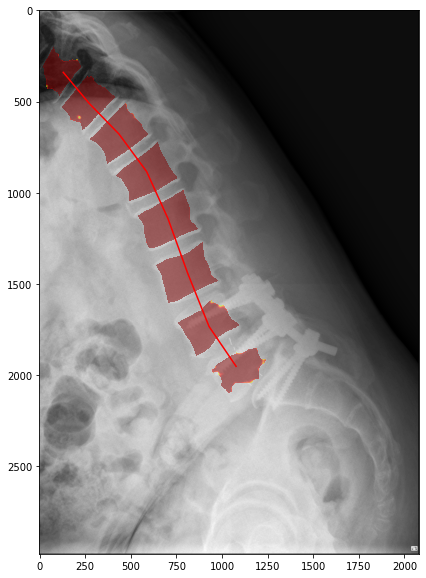

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(full_img, cmap='gray')

conf_threshold = 0.5
outimgs = []
seg_imgs = []
centers = []

label = [l for l in label if l['conf'] > conf_threshold]

for ix in range(len(label)):

    if label[ix]['label'] == 'S':
        break

    print(label[ix])
    x_c, y_c = label[ix]['x_center'], label[ix]['y_center']
    w, h = label[ix]['box_width'], label[ix]['box_height']
    box = (x_c-w/2, y_c-h/2, x_c+w/2, y_c+h/2)
    seg_img = full_img.crop(box)
    seg_imgs.append(seg_img)
    centers.append((x_c, y_c))

    if histeq == True:
        input_img = Image.fromarray(equalizeHist(np.array(seg_img)))
    else:
        input_img = seg_img

    input_img = TF.resize(input_img, [224,224])
    input_img = TF.to_tensor(input_img)

    shape_model.eval()
    output = shape_model(input_img.unsqueeze(0))
    prob = torch.sigmoid(output)

    prob = TF.resize(prob, [*(seg_img.size)][::-1])
    outimg = prob.squeeze().detach().numpy()
    outimgs.append(outimg)

    # print(outimg.shape)
    # print(np.asarray(tot_img).shape)
    # print(box)

    # new image is outimg with padding = 0
    new_img = np.zeros(np.asarray(full_img).shape)

    for i in range(outimg.shape[0]):
        for j in range(outimg.shape[1]):
            new_img[int(box[1]+i),int(box[0]+j)] = outimg[i,j]


    masked = np.ma.masked_where(new_img < 0.8 , new_img)

    col = 'jet'

    plt.imshow(masked, alpha=0.5, cmap=col)

xcs, ycs = zip(*centers)
plt.plot(xcs, ycs, 'r-')

plt.show()

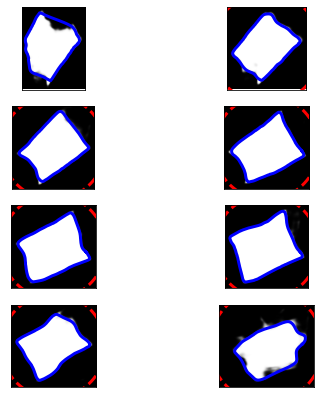

In [32]:
fig, ax = plt.subplots(4,2,figsize=(7, 7))
snakes = []

for idx, outimg in enumerate(outimgs):    

    s = np.linspace(0, 2*np.pi, 400)
    r = outimg.shape[0]/2 + 250*np.sin(s)
    c = outimg.shape[1]/2 + 250*np.cos(s)
    init = np.array([r, c]).T

    # beta = the smoothness
    snake = active_contour(gaussian(outimg,sigma=3),
                        init, alpha=0.015, beta=3, gamma=0.001)

    ax[int((idx)/2), (idx)%2].imshow(outimg, cmap=plt.cm.gray)
    ax[int((idx)/2), (idx)%2].plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax[int((idx)/2), (idx)%2].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax[int((idx)/2), (idx)%2].set_xticks([]), ax[int((idx)/2), (idx)%2].set_yticks([])
    ax[int((idx)/2), (idx)%2].axis([0, outimg.shape[1], outimg.shape[0], 0])

    snakes.append(snake)

    # plt.show()

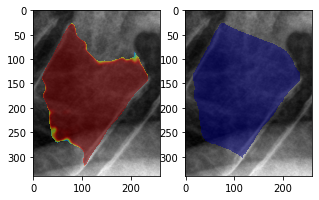

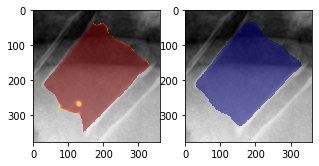

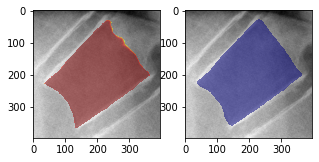

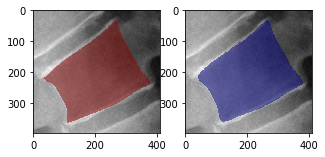

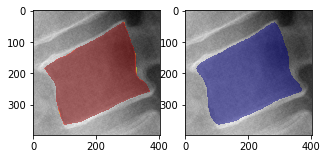

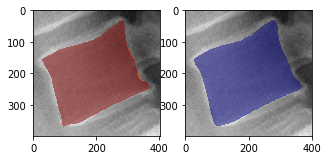

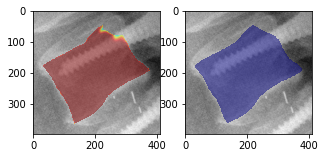

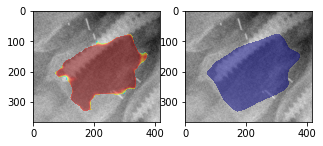

In [31]:
outlines = []

for idx, snake in enumerate(snakes):
    outline = Image.new(size=outimgs[idx].shape[::-1], mode='1')
    ImageDraw.Draw(outline).polygon([(int(s[1]), int(s[0])) for s in snake],outline=1, fill=1)
    # print(np.array(outline))
    outlines.append(outline)
    msk1 = np.ma.masked_where(outimgs[idx] < 0.8, outimgs[idx])
    msk2 = np.ma.masked_where(np.array(outline) < 0.8, np.array(outline))

    fig, ax = plt.subplots(1,2, figsize=(5,5))
    ax[0].imshow(seg_imgs[idx], cmap='gray')
    ax[0].imshow(msk1, alpha=0.5, cmap='jet')
    ax[1].imshow(seg_imgs[idx], cmap='gray')
    ax[1].imshow(msk2, alpha=0.5, cmap='jet')

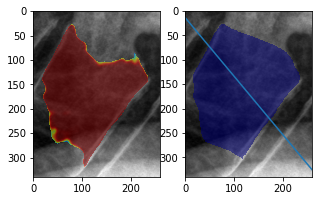

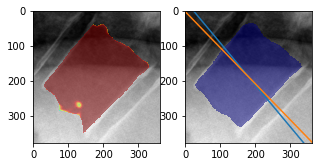

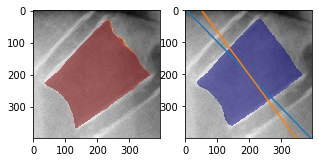

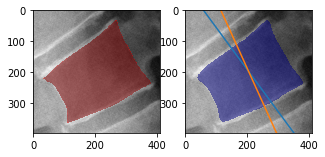

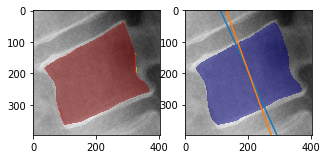

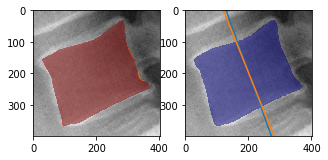

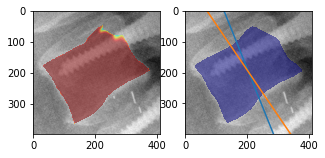

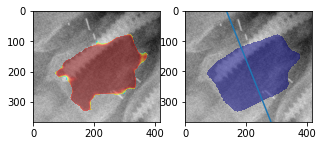

In [71]:
for idx, snake in enumerate(snakes):
    outline = Image.new(size=outimgs[idx].shape[::-1], mode='1')
    ImageDraw.Draw(outline).polygon([(int(s[1]), int(s[0])) for s in snake],outline=1, fill=1)
    # print(np.array(outline))
    msk1 = np.ma.masked_where(outimgs[idx] < 0.8, outimgs[idx])
    msk2 = np.ma.masked_where(np.array(outline) < 0.8, np.array(outline))

    fig, ax = plt.subplots(1,2, figsize=(5,5))
    ax[0].imshow(seg_imgs[idx], cmap='gray')
    ax[0].imshow(msk1, alpha=0.5, cmap='jet')
    ax[1].imshow(seg_imgs[idx], cmap='gray')
    ax[1].imshow(msk2, alpha=0.5, cmap='jet')


    if idx == 0:
        x1, y1 = centers[idx]
        x2, y2 = centers[idx+1]      
        
        a2 = (y1-y2)/(x1-x2)
        b2 = seg_imgs[idx].size[1]/2 - a2 * seg_imgs[idx].size[0]/2

        X = np.linspace(-500,500)
        ax[1].plot(X, a2*X+b2)  
    elif idx == len(snakes)-1:

        x1, y1 = centers[idx]
        x3, y3 = centers[idx-1]      
        
        a2 = (y3-y1)/(x3-x1)
        b1 = seg_imgs[idx].size[1]/2 - a1 * seg_imgs[idx].size[0]/2

        X = np.linspace(-500,500)
        ax[1].plot(X, a1*X+b1)  
    
    else:
        x1, y1 = centers[idx]
        x2, y2 = centers[idx+1]
        x3, y3 = centers[idx-1]

        a1 = (y3-y1)/(x3-x1)
        b1 = seg_imgs[idx].size[1]/2 - a1 * seg_imgs[idx].size[0]/2

        a2 = (y1-y2)/(x1-x2)
        b2 = seg_imgs[idx].size[1]/2 - a2 * seg_imgs[idx].size[0]/2

        X = np.linspace(-500,500)

        ax[1].plot(X, a1*X+b1)
        ax[1].plot(X, a2*X+b2)
    
    ax[1].set_xlim([0,seg_imgs[idx].size[0]])
    ax[1].set_ylim([seg_imgs[idx].size[1],0])

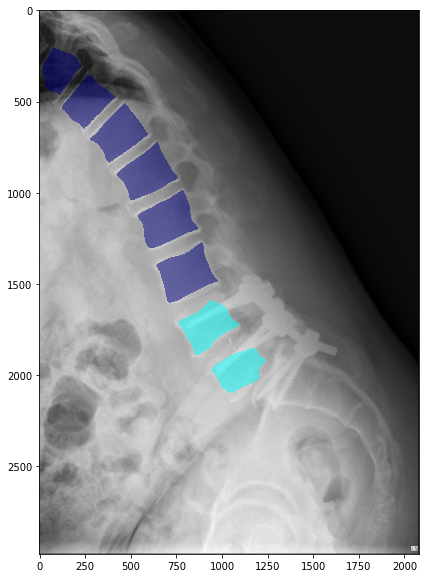

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(full_img, cmap='gray')

# to detect screw
screw_transformer = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

for ix in range(len(label)):

    if label[ix]['label'] == 'S':
        break

    x_c, y_c = label[ix]['x_center'], label[ix]['y_center']
    w, h = label[ix]['box_width'], label[ix]['box_height']
    box = (x_c-w/2, y_c-h/2, x_c+w/2, y_c+h/2)

    new_img = np.zeros(np.asarray(full_img).shape)
    outline = np.array(outlines[ix])

    for i in range(outline.shape[0]):
        for j in range(outline.shape[1]):
            new_img[int(box[1]+i),int(box[0]+j)] = outline[i,j]

    masked = np.ma.masked_where(new_img < 0.8 , new_img)

    col = 'jet'

    if torch.max(screw_model(screw_transformer(seg_imgs[ix]).unsqueeze(0)), 1)[1] == 1:
        col = 'cool'

    plt.imshow(masked,alpha=0.5, cmap=col)

plt.show()

(366, 418)
find at 32
find at 324
find at 119
find at 352
[(226, 32), (119, 261), (352, 145), (238, 324)]
(327.79393923934, 88.24769132100262)
(90.20606076066001, 174.51471862576142)
(336.9863273947651, 257.2462120245875)
(129.80404050710666, 303.2081528017131)


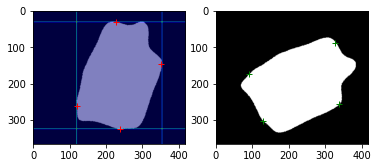

In [65]:
# note outlines store PIL image
ix = 7

corners = []

temp = outlines[ix]
temp = TF.rotate(temp, angle=45)

outline = np.array(temp)
bound = np.empty(outline.shape)
print(bound.shape)
for i in range(bound.shape[0]):
    if np.max(outline[i, :]) != 0:

        max_idx = [k[0] for k in np.argwhere(outline[i, :] == np.max(outline[i, :]))]
        corners.append((max_idx[int(len(max_idx)/2)], i))
        
        print('find at {}'.format(i))
        bound[i, :] = np.ones(bound.shape[1]) * 255
        # plt.imshow(bound, alpha=0.3, cmap='jet')
        break

for i in range(bound.shape[0]-1, 0, -1):
    if np.max(outline[i, :]) != 0:

        max_idx = [k[0] for k in np.argwhere(outline[i, :] == np.max(outline[i, :]))]
        corners.append((max_idx[int(len(max_idx)/2)], i))
        
        print('find at {}'.format(i))
        bound[i, :] = np.ones(bound.shape[1]) * 255
        # plt.imshow(bound, alpha=0.3, cmap='jet')
        break

for i in range(bound.shape[1]):
    if np.max(outline[:, i]) != 0:

        max_idx = [k[0] for k in np.argwhere(outline[:, i] == np.max(outline[:, i]))]
        corners.append((i, max_idx[int(len(max_idx)/2)]))

        print('find at {}'.format(i))
        bound[:, i] = np.ones(bound.shape[0]) * 255
        # plt.imshow(bound, alpha=0.3, cmap='jet')
        break

for i in range(bound.shape[1]-1, 0, -1):
    if np.max(outline[:, i]) != 0:

        max_idx = [k[0] for k in np.argwhere(outline[:, i] == np.max(outline[:, i]))]
        corners.append((i, max_idx[int(len(max_idx)/2)]))
        
        print('find at {}'.format(i))
        bound[:, i] = np.ones(bound.shape[0]) * 255
        break

corners.sort(key=lambda c: c[0], reverse=False)
if corners[0][1] > corners[1][1]:
    corners[1], corners[0] = corners[0], corners[1]
if corners[2][1] > corners[3][1]:
    corners[2], corners[3] = corners[3], corners[2]

# 0 2
# 1 3
print(corners)

rad45 = -np.deg2rad(45)
rot = np.array([[np.cos(rad45), -np.sin(rad45)],[np.sin(rad45), np.cos(rad45)]])

fig, ax = plt.subplots(1,2)

for corner in corners:
    ax[0].plot(*corner, 'r+')
    k = np.array( [corner[0]-temp.size[0]/2, corner[1]-temp.size[1]/2])
    corner = np.matmul(k, rot)
    corner = (corner[0]+temp.size[0]/2, corner[1]+temp.size[1]/2)
    print(corner)
    ax[1].plot(*corner, 'g+')

ax[0].imshow(temp)
temp = TF.rotate(temp, angle=-45)
ax[1].imshow(temp)

ax[0].imshow(bound, alpha=0.5, cmap='jet')

In [6]:
def edge_segment(cord1, cord2, outline, upper=True, n=3):

    if cord1[0] < cord2[0]:
        cord1, cord2 = cord2, cord1

    if isinstance(outline, Image.Image):
        outline = np.array(outline)
    
    kx = [int(cord2[0] + i*(cord1[0]-cord2[0])/n) for i in range(n+1)]
    ky = [int(cord2[1] + i*(cord1[1]-cord2[1])/n) for i in range(n+1)]

    orthogonal_vec = np.array([-(cord1[1]-cord2[1]), cord1[0]-cord2[0]])
    orthogonal_vec = orthogonal_vec / np.sqrt(np.square(orthogonal_vec[0]) + np.square(orthogonal_vec[1]))

    if upper == False:
        orthogonal_vec *= -1

    intersection = []

    for i in range(1, len(kx)-1):
        t=0
        if outline[ky[i], kx[i]] == True:
            i1, i2 = kx[i], ky[i]
            while True:
                t1 = round(kx[i] - t * orthogonal_vec[0])
                t2 = round(ky[i] - t * orthogonal_vec[1])
                if t1<0 or t2<0 or t1>=outline.shape[1] or t2>=outline.shape[0] or outline[t2, t1] == False:
                    intersection.append((i1,i2))
                    break
                else:
                    t+=1
                    i1, i2 = t1, t2
        else:
            i1, i2 = kx[i], ky[i]
            while True:
                t1 = round(kx[i] + t * orthogonal_vec[0])
                t2 = round(ky[i] + t * orthogonal_vec[1])
                if t1<0 or t2<0 or t1>=outline.shape[1] or t2>=outline.shape[0] or outline[t2, t1] != False:
                    intersection.append((t1,t2))
                    break
                else:
                    t+=1
                    i1, i2 = t1, t2

    intersection.append((kx[-1], ky[-1]))
    intersection = [(kx[0], ky[0])] + intersection

    return intersection

In [71]:
n = 3

if corners[2][0] > corners[0][0]:
    corners[0], corners[2] = corners[2], corners[0]

kx = [corners[2][0] + int(i*(corners[0][0]-corners[2][0])/n) for i in range(n+1)]
ky = [corners[2][1] + int(i*(corners[0][1]-corners[2][1])/n) for i in range(n+1)]
print(kx)
print(ky)
# print(len(k) == len(kx))

orthogonal_vec = np.array([-(corners[0][1]-corners[2][1]), corners[0][0]-corners[2][0]])
orthogonal_vec = orthogonal_vec / np.sqrt(np.square(orthogonal_vec[0]) + np.square(orthogonal_vec[1]))

orthogonal_line = np.empty(outline.shape)
interscetion = []

for i in range(1, len(kx)-1):
   orthogonal_line[ky[i], kx[i]] = 255
   
   t = 0
   while True:
       t1 = round(kx[i] + t * orthogonal_vec[0])
       t2 = round(ky[i] + t * orthogonal_vec[1])
       if not (t1 >= 0 and t1 < orthogonal_line.shape[1]):
           break
       if not (t2 >= 0 and t2 < orthogonal_line.shape[0]):
            break
       t += 1

       orthogonal_line[t2, t1] = 255

   t = 0
   while True:
       t1 = round(kx[i] - t * orthogonal_vec[0])
       t2 = round(ky[i] - t * orthogonal_vec[1])
       if not (t1 >= 0 and t1 < orthogonal_line.shape[1]):
           break
       if not (t2 >= 0 and t2 < orthogonal_line.shape[0]):
            break
       t += 1

       orthogonal_line[t2, t1] = 255

   t=0
   tracks = []
   if outline[ky[i], kx[i]] == True:
       i1, i2 = kx[i], ky[i]
       while True:
           t1 = round(kx[i] - t * orthogonal_vec[0])
           t2 = round(ky[i] - t * orthogonal_vec[1])
           if outline[t2, t1] == False:
               interscetion.append((i1,i2))
            #    plt.plot(t2,t1, 'r+')
               break
           else:
               t+=1
               i1, i2 = t1, t2
               tracks.append((i1,i2))
   else:
       i1, i2 = kx[i], ky[i]
       while True:
           t1 = round(kx[i] + t * orthogonal_vec[0])
           t2 = round(ky[i] + t * orthogonal_vec[1])
           if outline[t2, t1] != False:
               interscetion.append((t1,t2))
               break
           else:
               t+=1
               i1, i2 = t1, t2

        


plt.imshow(outlines[ix])
plt.imshow(orthogonal_line,alpha=0.5, cmap='jet')

print('===uncorrected===')

for k in zip(kx, ky):
    print(k)
    gstr, = plt.plot(*k, 'g+')

print('===corrected===')
interscetion.append((kx[-1], ky[-1]))
interscetion = [(kx[0], ky[0])] + interscetion
for intersect in interscetion:
    # print('{} = {}'.format(intersect, outline[intersect[0], intersect[1]]))
    rstr, = plt.plot(*intersect, 'r+')

plt.legend([rstr, gstr], ['corrected','uncorrected'])

[47.77965388946717, 151.77965388946717, 255.77965388946717, 359.77965388946717]
[52.97561338236048, 66.97561338236048, 80.97561338236048, 94.97561338236048]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
seg_n = 7

a = edge_segment(corners[0], corners[2], outline, n=seg_n)
b = edge_segment(corners[1], corners[3], outline, upper=False, n=seg_n)
plt.imshow(outlines[ix])

# x coordinate in ascending order
a.sort(key=lambda tup: tup[0])
b.sort(key=lambda tup: tup[0])

lengths = []

for x1, x2 in zip(a, b):

    print('{:.3f}'.format(np.sqrt(np.square(x1[0]-x2[0])+np.square(x1[1]-x2[1]))))

    lengths.append(np.sqrt(np.square(x1[0]-x2[0])+np.square(x1[1]-x2[1])))

    plt.plot(*x1, 'r+')
    plt.plot(*x2, 'r+')
    plt.plot([x1[0], x2[0]], [x1[1], x2[1]], 'r-')

In [ ]:
print(lengths)
for idx in range(len(lengths)-1):

    print(lengths[idx]/lengths[idx+1])

In [ ]:
unlabel_path = 'C:\\Users\\user\\OneDrive\\桌面\\vertex\\content\\DATA_unlabel'
unlabel_dirs = [os.path.join(unlabel_path, fp) for fp in os.listdir(unlabel_path) if not 'notX' in fp]

unlabel_dict = dict()
topath = lambda fp: os.path.join(unlabel_dir, fp)

for unlabel_dir in unlabel_dirs:
    unlabel_dict[str(unlabel_dir)] = [topath(fp) for fp in os.listdir(unlabel_dir) if fp.endswith('.bmp')]

# yolo detection
def detect_Xray_image(dir_path, dest_path='../pred_result/'):

    if not os.path.isdir(dir_path):
        raise IsADirectoryError('File {} is not a directory'.format(dir_path))

    else:
        # os.mkdir(dest_dir)
        weight_path = 'C:/Users/user/OneDrive/桌面/ressult_good/runs_result/exp/weights/best.pt'
        print(dir_path)
        source_path = dir_path
        filename = dir_path.split('\\')[-1]
        conf = '0.4'

        print('=========source {}========='.format(source_dir))

        %cd ./content/yolov5/
        !python ./detect.py --weights $weight_path --img 400 --conf $conf --source $source_path --save-conf --save-txt --project $dest_path --name $filename
        %cd ../../

        print('=========output saved at {}========='.format(dest_path))

# for i in range(len(unlabel_dirs)):
#     detect_Xray_image(list(unlabel_dict.keys())[i])

In [ ]:
result_dir = 'content\\pred_result'

label_paths = []
image_paths = []
topath = lambda fp: os.path.join(label_dir_path, fp)

conf_threshold = 0.8

# only contain directory with number
for output_dir in [rd for rd in os.listdir(result_dir) if not 'exp' in rd]:
        label_dir_path = os.path.join(result_dir, output_dir, 'labels')
        label_paths.extend([topath(fp) for fp in os.listdir(label_dir_path)])

keys = [k for k in list(unlabel_dict.keys())]
for key in keys:
    image_paths.extend(unlabel_dict[key])

label_paths.sort(key=lambda x: x.split('\\')[-1])
image_paths.sort(key=lambda x: x.split('\\')[-1])

# different length (may errorly include some paths)
if len(image_paths) != len(label_paths):
    raise IndexError("Inconsistent length for the image list({}) and label list({})".format(len(image_paths), len(label_paths)))

# crop images, [xc, yc, w, h, conf], complete spine images
images, labels, full_imgs = [], [], []
for label_fp, image_fp in zip(label_paths, image_paths):
   
    img = Image.open(image_fp)
    full_imgs.append(img)
    label = read_label(label_fp, img.size)
    for l in label:
        xc, yc, w, h = l['x_center'], l['y_center'], l['box_width'], l['box_height']
        box = (xc-w/2, yc-h/2, xc+w/2, yc+h/2)
        images.append(img.crop(box))
        labels.append(l)

print(len(labels))

# todo unet detection

In [9]:
'''
seg_img: the input image of single vertex (cropped from yolo)
Histeq: preprocessing with Histogram equalization (depend on model)
Snake: fine tune with Snake
'''
def shape_detect(seg_img, Histeq=True, Snake=True):

    # Histogram equalization
    if histeq == True:
        input_img = Image.fromarray(equalizeHist(np.array(seg_img)))
    else:
        input_img = seg_img

    # input transformation
    input_img = TF.resize(input_img, [224,224])
    input_img = TF.to_tensor(input_img)

    # detection (no gpu so just do one by one)
    shape_model.eval()
    output = shape_model(input_img.unsqueeze(0))
    prob = torch.sigmoid(output)

    prob = TF.resize(prob, [*(seg_img.size)][::-1])
    outimg = prob.squeeze().detach().numpy()

    masked = np.ma.masked_where(outimg < 0.8 , outimg)

    # tunning with active contour model
    if Snake:
        s = np.linspace(0, 2*np.pi, 400)
        r = outimg.shape[0]/2 + 250*np.sin(s)
        c = outimg.shape[1]/2 + 250*np.cos(s)
        init = np.array([r, c]).T

        # beta = the smoothness
        snake = active_contour(gaussian(outimg,sigma=3),
                            init, alpha=0.015, beta=3, gamma=0.001)

        outline = Image.new(size=outimg.shape[::-1], mode='1')
        ImageDraw.Draw(outline).polygon(
            [(int(s[1]), int(s[0])) for s in snake],
            outline=1,
            fill=1
        )
        masked = np.ma.masked_where(np.array(outline) < 0.8, np.array(outline))

    return masked

In [59]:
count_filtered = 0
max_bar = 60

print('total image count: {}'.format(len(images)))
begin_time = time.time()
print('begin time {}'.format(time.ctime()))
for idx, (image, label) in enumerate(zip(images, labels)):

    # filter bad prediction
    if label['conf'] < 0.8:
        cont_filtered += 1
        continue
    elif label['label'] == 'S':
        continue

    # predict and save, filename format 0123456_FILE0_L5.txt
    mask = shape_detect(image)
    save_dir = os.path.join(result_dir,label['path'].split('\\')[-1].split('_')[0], 'masks')
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, label['path'].split('\\')[-1].split('.')[0] + '_' + label['label'] + '.txt')
    np.savetxt(save_path, mask, fmt='%d')

    # progress bar and other panel
    bar_cnt = int((idx+1) * max_bar / len(images))
    est_time = int((len(images)-idx+1) * (time.time()-begin_time)/(idx+1))
    progress_bar = '[' + \
        ''.join(['#' for i in range(bar_cnt)]) + \
        ''.join([' ' for i in range(max_bar-bar_cnt)]) + ']' + \
        ' last {:.0f} seconds, completed({}/{})'.format(est_time, idx+1, len(images))

    sys.stdout.write('\r' + progress_bar)

print('\nfinish time {}'.format(time.ctime()))
time_cost = time.time()-begin_time

if time_cost < 60:
    s = str(int(time_cost)) + ' seconds'
elif time_cost < 3600:
    s = str(int(time_cost/60)) + ' minutes ' + str(int(time_cost%60)) + ' seconds'
else:
    s = str(int(time_cost/3600)) + ' hours ' + \
        str(int((time_cost%3600)/60)) + ' minutes ' + \
        str(int(time_cost%3600%60)) + ' seconds'

print('total time cost ' + s)
print('data deprecated {}'.format(count_filtered))

NameError: name 'images' is not defined

In [7]:
def get_corner(mask, rotate=False):

    outline = mask

    corners = []

    if rotate == True:
        temp = TF.rotate(Image.fromarray(outline), angle=45, expand=True)
        outline = np.array(temp)

    for i in range(outline.shape[0]):
        if np.max(outline[i, :]) != 0:

            max_idx = [k[0] for k in np.argwhere(outline[i, :] == np.max(outline[i, :]))]
            corners.append((max_idx[int(len(max_idx)/2)], i))
            break

    for i in range(outline.shape[0]-1, 0, -1):
        if np.max(outline[i, :]) != 0:

            max_idx = [k[0] for k in np.argwhere(outline[i, :] == np.max(outline[i, :]))]
            corners.append((max_idx[int(len(max_idx)/2)], i))
            break

    for i in range(outline.shape[1]):
        if np.max(outline[:, i]) != 0:

            max_idx = [k[0] for k in np.argwhere(outline[:, i] == np.max(outline[:, i]))]
            corners.append((i, max_idx[int(len(max_idx)/2)]))
            break

    for i in range(outline.shape[1]-1, 0, -1):
        if np.max(outline[:, i]) != 0:

            max_idx = [k[0] for k in np.argwhere(outline[:, i] == np.max(outline[:, i]))]
            corners.append((i, max_idx[int(len(max_idx)/2)]))
            break

    if rotate == True:
        r_corner = []
        rad45 = -np.deg2rad(45)
        rot = np.array([[np.cos(rad45), -np.sin(rad45)],[np.sin(rad45), np.cos(rad45)]])

        for idx, corner in enumerate(corners):
            k = np.array( [corner[0]-temp.size[0]/2, corner[1]-temp.size[1]/2])
            corner = np.matmul(k, rot)
            corner = (corner[0]+mask.shape[1]/2, corner[1]+mask.shape[0]/2)
            corners[idx] = corner

    if len(corners) != 4:
        return corners

    corners.sort(key=lambda c: c[0], reverse=False)
    if corners[0][1] > corners[1][1]:
        corners[1], corners[0] = corners[0], corners[1]
    if corners[2][1] > corners[3][1]:
        corners[2], corners[3] = corners[3], corners[2]
        

    return corners

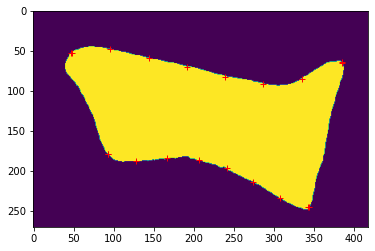

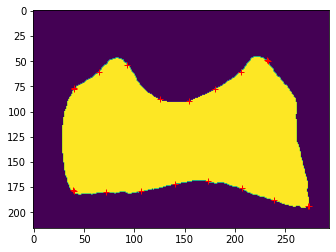

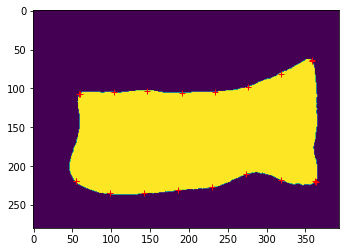

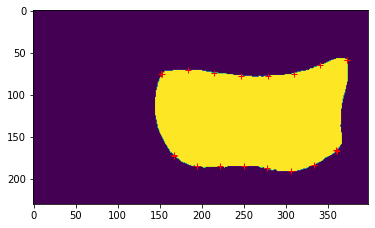

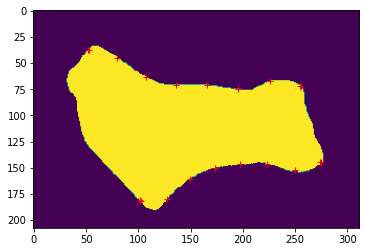

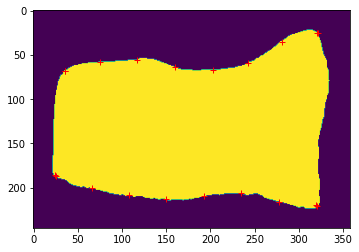

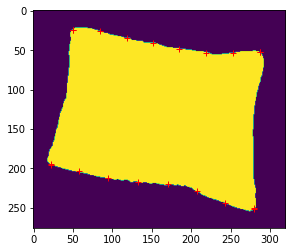

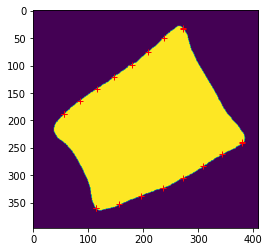

In [8]:
result_dir = 'content\\pred_result'
for target_dir in os.listdir(result_dir):
    
    if not str.isnumeric(target_dir):
        continue
    
    masks_dir = os.path.join(result_dir, target_dir, 'masks')
    for idx, fname in enumerate(os.listdir(masks_dir)):
        fp = os.path.join(masks_dir, fname)
        msk = np.loadtxt(fp, dtype=np.int32)

        seg_n = 7

        corners = get_corner(mask=msk, rotate=True)

        a = edge_segment(corners[0], corners[2], msk, n=seg_n)
        b = edge_segment(corners[1], corners[3], msk, upper=False, n=seg_n)

        # x coordinate in ascending order
        a.sort(key=lambda tup: tup[0])
        b.sort(key=lambda tup: tup[0])

        plt.figure()
        plt.imshow(msk)
        for corner in corners:
            plt.plot(*corner, 'r+')

        for axy, bxy in zip(a,b):
            plt.plot(*axy, 'r+')
            plt.plot(*bxy, 'r+')

        break

In [38]:
features = []
seg_n = 7

for target_dir in os.listdir(result_dir):
    
    if not str.isnumeric(target_dir):
        continue
    
    masks_dir = os.path.join(result_dir, target_dir, 'masks')
    for idx, fname in enumerate(os.listdir(masks_dir)):
        fp = os.path.join(masks_dir, fname)
        msk = np.loadtxt(fp, dtype=np.int32)

        file_id = fname.split('_')[0] + '_' + fname.split('_')[1]
        position = fname.split('.')[0].split('_')[-1]
        if position == 'S':
            continue

        corners = get_corner(mask=msk, rotate=True)

        a = edge_segment(corners[0], corners[2], msk, n=seg_n)
        b = edge_segment(corners[1], corners[3], msk, upper=False, n=seg_n)

        # x coordinate in ascending order
        a.sort(key=lambda tup: tup[0])
        b.sort(key=lambda tup: tup[0])

        # a = [corners[0]] + a + [corners[2]]
        # b = [corners[1]] + b + [corners[3]]

        feature = []
        feature.append(file_id)
        feature.append(position)
        feature.extend([np.sqrt((ax[0]-bx[0])**2 + (ax[1]-bx[1])**2) for ax, bx in zip(a,b)])

        features.append(feature)

columns = ['ID', 'position'] + ['Len'+str(i) for i in range(8)]

df = pd.DataFrame(
    features, 
    columns= columns
    )
df.head()

,ID,position,Len0,Len1,Len2,Len3,Len4,Len5,Len6,Len7
0,01549476_FILE0,L1,134.134261,142.863571,127.098387,116.841773,114.017543,122.690668,150.442680,185.809042
1,01549476_FILE0,L2,220.907220,224.269927,212.037732,204.039212,201.357890,202.094038,211.286535,207.694487
2,01549476_FILE0,L3,225.008889,230.034780,224.109348,214.189169,206.242576,201.300770,227.431308,233.548710
3,01549476_FILE0,L4,221.578429,228.790297,221.652882,208.614477,200.489401,199.564526,216.748702,213.759210
4,01549476_FILE0,L5,228.359366,230.932891,224.178500,217.554591,206.951685,191.415778,171.303824,143.265488


In [39]:
df2 = df
df2['Len_ratio0'] = df2['Len1']/df2['Len0']
df2['Len_ratio1'] = df2['Len3']/df2['Len0']
df2['Len_ratio2'] = df2['Len5']/df2['Len0']
df2['Len_ratio3'] = df2['Len7']/df2['Len0']
df2['pos_encode'] = np.array([1 if 'T' in a else 0 for a in df2['position']])
df2.head()

,ID,position,Len0,Len1,Len2,Len3,Len4,Len5,Len6,Len7,Len_ratio0,Len_ratio1,Len_ratio2,Len_ratio3,pos_encode
0,01549476_FILE0,L1,134.134261,142.863571,127.098387,116.841773,114.017543,122.690668,150.442680,185.809042,1.065079,0.871081,0.914686,1.385247,0
1,01549476_FILE0,L2,220.907220,224.269927,212.037732,204.039212,201.357890,202.094038,211.286535,207.694487,1.015222,0.923642,0.914837,0.940189,0
2,01549476_FILE0,L3,225.008889,230.034780,224.109348,214.189169,206.242576,201.300770,227.431308,233.548710,1.022336,0.951914,0.894635,1.037953,0
3,01549476_FILE0,L4,221.578429,228.790297,221.652882,208.614477,200.489401,199.564526,216.748702,213.759210,1.032548,0.941493,0.900650,0.964711,0
4,01549476_FILE0,L5,228.359366,230.932891,224.178500,217.554591,206.951685,191.415778,171.303824,143.265488,1.011270,0.952685,0.838222,0.627369,0


In [40]:
df2.describe()

,Len0,Len1,Len2,Len3,Len4,Len5,Len6,Len7,Len_ratio0,Len_ratio1,Len_ratio2,Len_ratio3,pos_encode
count,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000,937.000000
mean,153.683517,165.978527,164.345275,160.857253,160.341682,162.671064,170.520395,166.587023,1.142946,1.221989,1.281964,1.307729,0.477054
std,52.441623,51.289196,48.474264,45.842233,44.454286,44.112426,47.287715,51.796350,0.430458,1.170251,1.344156,1.371173,0.499740
min,7.071068,29.120440,31.622777,34.176015,27.202941,15.811388,7.211103,1.414214,0.772252,0.543618,0.149842,0.018110,0.000000
25%,121.498971,134.629120,132.098448,128.860390,129.139460,132.544332,139.316187,137.233378,1.023479,0.939246,0.922455,0.932031,0.000000
50%,153.326449,162.249807,157.917700,154.324334,153.062079,156.000000,166.868211,167.107750,1.064630,1.012147,1.015991,1.081565,0.000000
75%,188.470157,200.810856,199.491854,196.163197,194.092761,195.734514,203.022166,202.061872,1.130374,1.135623,1.171046,1.249393,1.000000
max,312.827428,302.491322,304.310696,310.721740,320.702354,334.293284,342.118401,329.091173,10.104454,17.477414,17.903552,22.522877,1.000000


(0.0, 1.4)

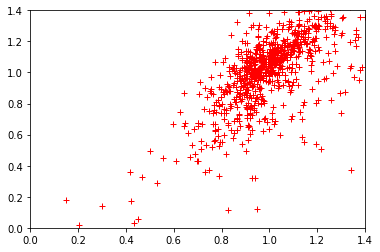

In [41]:
for idx, row in df2.iterrows():

    plt.plot(row['Len_ratio2'], row['Len_ratio3'], 'r+')

plt.xlim([0,1.4])
plt.ylim([0,1.4])

In [25]:
print(len(df[df['Len_ratio2']<0.5]))

8


In [26]:
import pickle

with open('./MLmodel.pickle', 'rb') as f:
    mds = pickle.load(f)

In [45]:
preds = mds[0]['knn'].predict(df2.drop(['ID', 'position'], axis=1))
for pred, pos, fid in zip(preds, df2['position'], df2['ID']):
    if pred == 0:
        print(pos, fid)

L1 01549476_FILE0
T6 01549476_FILE0
L1 01549476_FILE1
L1 01549476_FILE3
L3 01549476_FILE3
T9 01549476_FILE3
L1 01549476_FILE4
T11 01549476_FILE4
L1 01750251_FILE0
L2 01750251_FILE0
L5 01750251_FILE0
T11 01750251_FILE0
L1 01750251_FILE10
L2 01750251_FILE10
L3 01750251_FILE10
L4 01750251_FILE10
T10 01750251_FILE10
T5 01750251_FILE10
T6 01750251_FILE10
L2 01750251_FILE11
L3 01750251_FILE11
L4 01750251_FILE11
T11 01750251_FILE11
T12 01750251_FILE11
T5 01750251_FILE11
L1 01750251_FILE12
L2 01750251_FILE12
L5 01750251_FILE12
T11 01750251_FILE12
L2 01750251_FILE13
L3 01750251_FILE13
T10 01750251_FILE13
T8 01750251_FILE13
L2 01750251_FILE14
T12 01750251_FILE14
L2 01750251_FILE15
L3 01750251_FILE15
L1 01750251_FILE16
L2 01750251_FILE16
T7 01750251_FILE16
L1 01750251_FILE17
L2 01750251_FILE17
L3 01750251_FILE17
T12 01750251_FILE17
T8 01750251_FILE17
L1 01750251_FILE18
L2 01750251_FILE18
T12 01750251_FILE19
L2 01750251_FILE1
L3 01750251_FILE1
T5 01750251_FILE1
T7 01750251_FILE1
L1 01750251_FILE20

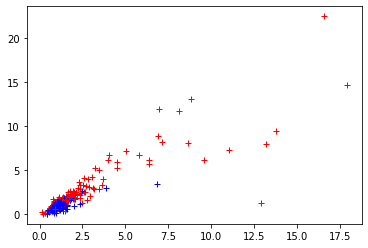

In [49]:
for (idx, row), pred in zip(df2.iterrows(), preds):

    col = 'r+' if pred == 0 else 'b+'

    plt.plot(row['Len_ratio2'], row['Len_ratio3'], col)

# plt.xlim([0,1.4])
# plt.ylim([0,1.4])